In [1]:
import csv
from pathlib import Path
import glob
import re
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pomegranate as pg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams

seed = 9292
np.random.seed(seed)
rand = np.random.RandomState(seed=seed)

In [2]:
class Recording:
    def __init__(self, csv):
        self._name = Path(csv).stem.split('.')[0]
        self._speaker = self._name.split('_')[0]
        self._personality = self._name.split('_')[-1]
        self._path = csv
        
    @property
    def id(self) -> str:
        """The recording identifier."""
        return self._name
    
    @property
    def speaker(self) -> str:
        """The speaker of the recording."""
        return self._speaker
    
    @property
    def path(self) -> str:
        """The path to the rov.csv parameters file."""
        return self._path

class Parameters(Recording):
    def __init__(self, csv):
        super().__init__(csv)
    
    def as_df(self) -> pd.DataFrame:
        """Creates a dataframe from the rov.csv parameters file."""
        
        # Load the annotations
        df = pd.read_csv(self._path).astype(np.float64) 
        
        # Select only the rotation vectors
        df = df[['Rx', 'Ry', 'Rz']]
        
        # Add personality column
        # df['personality'] = self._personality
        
        # Add speaker and recording identifier columns
        # df['speaker'] = self._speaker
        df['recording'] = self._name
        
        return df

class Annotations(Recording):
    def __init__(self, csv):
        self._params = Parameters(
            re.sub('/rov.csv', '/Normalized/rov.csv', 
                   re.sub('eaf.csv', 'rov.csv', 
                          re.sub('annotations', 'params', csv)))
        )
        super().__init__(csv)
    
    @property
    def params(self) -> Parameters:
        """Returns the corresponding {Parameters} object for the annotations."""
        return self._params        
    
    def as_df(self) -> pd.DataFrame:
        """Creates a dataframe from the eaf.csv annotations file."""
        
        # Load the annotations
        df = pd.read_csv(self._path)   
        
        # Select the gesture type, start-time, end-time and duration columns
        df = df[['type', 'start_time', 'end_time', 'during_time']]
        
        # Rename 'during_time' column to 'duration'
        df = df.rename(columns={'type': 'gesture', 'during_time': 'duration'})
        
        # Convert the 'duration' column to an integer
        df = df.astype({'start_time': 'int32', 'end_time': 'int32', 'duration': 'int32'})

        # Convert the units from milliseconds to frames (/1000 and *100)
        df.loc[:, ['start_time', 'end_time', 'duration']] //= 10
        
        # Add personality column
        # df['personality'] = self._personality
        
        # Add speaker and recording identifier columns
        # df['speaker'] = self._speaker
        df['recording'] = self._name
        
        # Reorder columns such that 'gesture' is the last column
        df = df[['start_time', 'end_time', 'duration', 'recording', 'gesture']]
        
        # Remove 'start' gestures
        df = df[df['gesture'] != 'start']
        
        return df

In [3]:
# File paths to all annotation CSV files
csvs = glob.glob('../annotations/*/eaf.csv/*.eaf.csv')

# Initialize {Annotations} object for each eaf.csv annotations file
anns = [Annotations(csv) for csv in csvs]

# Combine the parameters dataframes for each {Annotations} object
param_df = pd.concat(ann.params.as_df() for ann in anns)

# Combine the dataframes for each {Annotations} object
ann_df = pd.concat(ann.as_df() for ann in anns)

# Shuffle the annotations dataframe
ann_df = ann_df.sample(frac=1, random_state=rand).reset_index(drop=True)

# Create train-test splits on the annotations dataframe
ann_y = ann_df['gesture'] 
ann_X = ann_df.loc[:, ann_df.columns != 'gesture']
ann_X_train, ann_X_test, ann_y_train, ann_y_test = train_test_split(ann_X, ann_y, test_size=0.2)

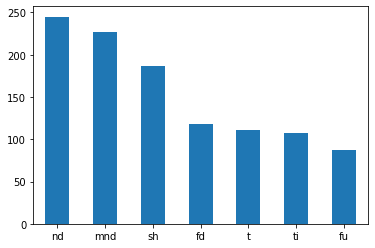

In [4]:
# Display prior counts for each class
prior_counts = ann_y_train.value_counts()
prior_counts.plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

## Gesture model class

A gesture model $\lambda_i$ is represented by a HMM which is trained on the observations of a particular gesture.

- **Training**: The training stage is done by the Baum-Welch algorithm–an application of expectation-maximization to Hidden Markov Models.
- **Predicting**: Predictions are done by calculating the (negative-log) likelihood of the model $\lambda_i$ generating the observation sequence $O$–this is done by the Forward algorithm. The `GestureModel#score` function can also compute the posterior by adding the negative log-prior of the gesture to the negative log-likelihood, but it is unclear whether this is necessary.
- **Emission distributions**: The emission distribution for each state can be modeled as a multivariate Gaussian over each of the rotation axes. `pg.MultivariateGaussianDistribution` can be used to specify a multivariate Gaussian distribution with some confusion matrix and mean vector. If we assume that each rotation axis is independent, instead of using a `pg.MultivariateGaussianDistribution` with a diagonal covariance matrix of rotation axis variances, we define the distribution as a `pg.IndependentComponentsDistribution` composed of one `pg.NormalDistribution` for each rotation axis–this is because it appears that the parameters of a `pg.MultivariateGaussianDistribution` are learned during the Baum-Welch training algorithm, which may not be what we want. This is unclear because the only other alternative to setting the parameters would be to take the mean and covariances of the rotation axes over all observation examples in the training data, but this treats all of the training data as one long observation, which seems incorrect. Another potential problem with this model is that the same emission distribution is used for each state.
- **Observation features**: It may or may not be necessary to consider all of the rotation axes for the observations of a particular gesture. For example, it can be assumed that nods do not have any lateral motion, and are restricted to rotations in the `Rz` (Pitch) axis, and hence, the other rotation axes should be ignored in the density functions for the emission distributions of each state. This reduces the dimensionality of the density functions for each state's emission distribution. This can be specified in the initialization function for the class: `GestureModel(..., features=['Rz'])`.
- **Transitions**: Both the initial transition distribution and state-wise transition probabilities are learned through the Baum-Welch training algorithm. This raises the question as to whether providing initial heuristic transition probabilities is necessary, and whether it results in a better likelihood. As a result, the `GestureModel#set_transition` and `GestureModel#set_initial` accept a `random` argument in addition to a `random_state` argument, for generating random transition probabilities. If using random probabilities, the provided array of transition probabilities should be empty.

In [5]:
class GestureModel:
    def __init__(self, gesture, n_states, features=['Rx', 'Ry', 'Rz']):
        # Retrieve the correct gesture annotation instances
        idx = ann_y_train[ann_y_train == gesture].index
        self.X = ann_X_train.ix[idx]
        
        # Set the name of the HMM and number of states
        self.name = gesture
        self.n_states = n_states
        
        # Set the observation features (rotation axes) that the model considers
        self.features = features
        self.features_idx = [i for i, axis in enumerate(['Rx', 'Ry', 'Rz']) if axis in features]
        
        # Create the HMM object
        self.model = pg.HiddenMarkovModel()
        
        # Calculate the prior for the gesture
        self.prior = (prior_counts / np.sum(prior_counts))[gesture]
        
    def set_transitions(self, transitions):
        """Sets the transition matrix for the gesture model."""
        assert all([np.isclose(1, sum([t for _, t in ts])) for _, ts in transitions.items()]), (
            'Transition probabilities out of each state must sum to one.')
        self.transitions = transitions
        
    def set_random_transitions(self, random_state=None):
        """Sets the transition probabilities by randomly sampling from a Dirichlet distribution."""
        if random_state is None:
            random_state = np.random.RandomState()
        elif isinstance(random_state, np.random.RandomState):
            random_state = random_state
        elif isinstance(random_state, int):
            random_state = np.random.RandomState(seed=random_state)
        else:
            raise TypeError("Expected 'random_state' to be of type 'None', 'int', or 'numpy.random.RandomState'")
            
        probs = random_state.dirichlet(np.ones(self.n_states), size=self.n_states)
        self.set_transitions({f"s{s+1}":[(f"s{t+1}", p) for t, p in enumerate(probs[s])] for (s, _), _ in np.ndenumerate(probs)})
        
    def set_initial(self, initial):
        """Sets the initial state distribution for the gesture model."""
        assert np.isclose(1, sum([p for _, p in initial])), 'Initial state distribution probabilities must sum to one.'
        self.initial = initial
        
    def set_random_initial(self, random_state=None):
        """Sets the initial state distribution by randomly sampling from a Dirichlet distribution."""
        if random_state is None:
            random_state = np.random.RandomState()
        elif isinstance(random_state, np.random.RandomState):
            random_state = random_state
        elif isinstance(random_state, int):
            random_state = np.random.RandomState(seed=random_state)
        else:
            raise TypeError("Expected 'random_state' to be of type 'None', 'int', or 'numpy.random.RandomState'")
            
        probs = random_state.dirichlet(np.ones(self.n_states), size=1).T
        self.set_initial([(f"s{s+1}", p[0]) for s, p in enumerate(probs)])
        
    def fit(self):
        """Fits the gesture model parameters to the provided observations via the Baum-Welch algorithm."""
        self.observations = []
        
        # Add each parameter sub-dataframe (for each annotated gesture) as an observation
        for _, row in self.X.iterrows():
            start, end, duration, recording = row
            gesture_df = param_df[param_df['recording'] == recording].iloc[start:end]
            self.observations.append(np.array(gesture_df[self.features]))
            
        combined = np.concatenate(self.observations)

        # Initialize a multivariate Gaussian emission distribution
        # NOTE: This HMM currently uses the same emission distribution for each state.
        dist = pg.MultivariateGaussianDistribution(
            np.mean(combined, axis=0), 
            np.multiply(np.std(combined, axis=0), np.eye(len(self.features)))
        )
        
        # Initialize a multivariate Gaussian emission distribution with strictly diagonal 
        # covariance matrix, or independent normal distributions for each rotation axis.
        # NOTE: This HMM currently uses the same emission distribution for each state.
        # dist = pg.IndependentComponentsDistribution([
        #     pg.NormalDistribution(np.mean(combined[:, ax]), np.std(combined[:, ax])) for ax in self.features_idx
        # ])
        
        # Create the state objects
        self.states = {name:pg.State(dist, name=name) for name in [f"s{i}" for i in range(1, self.n_states+1)]}
        
        # Add the states to the model
        self.model.add_states([state for _, state in self.states.items()])

        # Set initial state distribution        
        for (state, init_prob) in self.initial:
            self.model.add_transition(self.model.start, self.states[state], init_prob)
            
        # Add state transitions
        for source, targets in self.transitions.items():
            for target, transition in targets:
                self.model.add_transition(self.states[source], self.states[target], transition)
            
        # Finalize the model topology
        self.model.bake()

        # Perform the Baum-Welch algorithm to fit the model to the observations
        self.model.fit(self.observations)
        
    def score(self, observation, prior=False):
        """Calculates the negative log-likelihood (or posterior) of the gesture model generating the observation."""
        return -self.model.log_probability(observation[:, self.features_idx])-(self.prior if prior else 0)

## Creating the gesture models

One gesture model $\lambda_i=(A_i,B_i,\pi_i)$ is initialized and trained for each of the gestures: `nd`, `mnd`, `sh`, `fd`, `t`, `ti`, `fu`.

In [6]:
models = {}

In [7]:
# Train gesture model for the 'nd' gesture
models['nd'] = GestureModel(gesture='nd', n_states=5)#, features=['Rz'])
models['nd'].set_random_initial(random_state=rand)
models['nd'].set_random_transitions(random_state=rand)
models['nd'].fit()

In [8]:
# Train gesture model for the 'mnd' gesture
models['mnd'] = GestureModel(gesture='mnd', n_states=5)#, features=['Rz'])
models['mnd'].set_random_initial(random_state=rand)
models['mnd'].set_random_transitions(random_state=rand)
models['mnd'].fit()

In [9]:
# Train gesture model for the 'sh' gesture
# NOTE: Same as 'nd' gesture, but lateral
models['sh'] = GestureModel(gesture='sh', n_states=5)#, features=['Ry'])
models['sh'].set_random_initial(random_state=rand)
models['sh'].set_random_transitions(random_state=rand)
models['sh'].fit()

In [10]:
# Train gesture model for the 'fd' gesture
models['fd'] = GestureModel(gesture='fd', n_states=3)#, features=['Rz'])
models['fd'].set_random_initial(random_state=rand)
models['fd'].set_random_transitions(random_state=rand)
models['fd'].fit()

In [11]:
# Train gesture model for the 't' gesture
# NOTE: Similar to 'fu' or 'fd' gestures, but different rotation axis
models['t'] = GestureModel(gesture='t', n_states=3)#, features=['Ry'])
models['t'].set_random_initial(random_state=rand)
models['t'].set_random_transitions(random_state=rand)
models['t'].fit()

In [12]:
# Train gesture model for the 'ti' gesture
# NOTE: Same as 'fu' or 'fd' gestures, but lateral
models['ti'] = GestureModel(gesture='ti', n_states=3)#, features=['Rx'])
models['ti'].set_random_initial(random_state=rand)
models['ti'].set_random_transitions(random_state=rand)
models['ti'].fit()

In [13]:
# Train gesture model for the 'fu' gesture
# NOTE: Same as 'fu' gesture, but in opposite direction
models['fu'] = GestureModel(gesture='fu', n_states=3)#, features=['Rz'])
models['fu'].set_random_initial(random_state=rand)
models['fu'].set_random_transitions(random_state=rand)
models['fu'].fit()

## Creating a gesture classifier

In order to classify a gesture (or new observation $O'$), we must calculate the likelihood of each gesture model producing $O'$–that is, calculate $\mathbb{P}\left(O'\middle|\lambda_i\right)$ for each gesture model $\lambda_i$.

$O'$ is assigned to the gesture that corresponds with the gesture model that produced the highest likelihood (or smallest negative log-likelihood).

In [14]:
class GestureClassifier:
    def __init__(self, models, prior=False):
        self.models = models
        self.prior = prior
        
    def predict(self, observations):
        """Performs classification of an observation by calculating the score (negative-log likelihood or posterior) 
            of each of the provided gesture models generating the observation, and assigning the observation 
            to the gesture represented by the model which yielded the minimum score."""
        if isinstance(observations, np.ndarray):
            scores = {gesture:model.score(observations, prior=self.prior) for gesture, model in models.items()}
            best = min(scores, key=scores.get)
            return best, scores[best], scores
        elif isinstance(observations, list):
            assert all([isinstance(o, np.ndarray) for o in observations]), 'Expected observations to be list(nd.array)'
            predictions = []
            for observation in observations:
                scores = {gesture:model.score(observation, prior=self.prior) for gesture, model in models.items()}
                best = min(scores, key=scores.get)
                predictions.append((best, scores[best], scores))
            return predictions
        else:
            raise TypeError("Expected observations to be 'list(nd.array)' or 'nd.array'")

In [15]:
clf = GestureClassifier(models=models, prior=False)

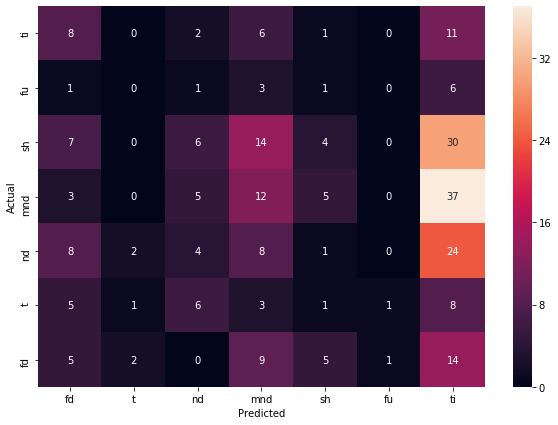

Accuracy: 0.1550
F1 score: 0.1666


In [16]:
def predict_test(clf):
    """Runs the provided gesture classifier on the test dataset."""
    observations = []
    
    for _, row in ann_X_test.iterrows():
        start, end, duration, recording = row
        gesture_df = param_df[param_df['recording'] == recording].iloc[start:end]
        observations.append(np.array(gesture_df[['Rx', 'Ry', 'Rz']]))
        
    return [g for g, _, _ in clf.predict(observations)]

def calculate_scores(predictions):
    """Calculates accuracy, F1 score and confusion matrix for provided test set predictions."""
    comp = pd.concat((pd.Series(list(ann_y_test)), pd.Series(predictions)), axis=1)
    comp = comp.rename(columns={0: 'true', 1: 'predicted'})
    comp['correct'] = comp['true'] == comp['predicted']
    
    cm = confusion_matrix(comp['true'], comp['predicted'])
    recall = np.mean(np.diag(cm) / np.sum(cm, axis=1))
    precision = np.mean(np.diag(cm) / np.sum(cm, axis=0))
    
    # Calculate F1 score (harmonic mean of precision and recall)
    f1 = 2.0 * precision * recall / (precision + recall)
    acc = np.sum(np.diag(cm)) / len(predictions)

    return acc, f1, cm

def plot_confusion_matrix(scores):
    """Plots the confusion matrix of predictions on the test set vs actual test labels."""
    cm_df = pd.DataFrame(scores[2], index=reversed(ann_y_test.unique()), columns=ann_y_test.unique())

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True)

    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Fix for matplotlib bug that cuts off top/bottom of seaborn visualizations
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

predictions = predict_test(clf)
scores = calculate_scores(predictions)
plot_confusion_matrix(scores)

print("Accuracy: {0:.4f}".format(scores[0]))
print("F1 score: {0:.4f}".format(scores[1]))